In [1]:
#@title requirements installs
!pip install wandb
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
#@title Imports
import os
import json
from datasets import load_dataset
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import wandb
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

id_to_label = {
    0: "Safety Harness",
    1: "Safety Mask",
    2: "Gloves",
    3: "Safety Glasses",
    4: "Face Mask"
}

In [3]:
#@title Download and create dataset
dataset = load_dataset("rishitdagli/cppe-5")

# Define a function to crop an image to its bounding box
def crop_to_bbox(image, bbox):
    xmin, ymin, width, height = bbox
    return image.crop((xmin, ymin, xmin + width, ymin + height))

# Define a function to check if the bounding box area is too small
def is_bbox_too_small(bbox, min_area=50*50):
    _, _, width, height = bbox
    return width * height < min_area

# Create the 'images/train' and 'images/test' directories if they don't exist
os.makedirs('images/train', exist_ok=True)
os.makedirs('images/test', exist_ok=True)

# Function to process and save images
def process_and_save_images(split):
    split_dir = f'images/{split}'
    jsonl_path = os.path.join(split_dir, 'image_info.jsonl')

    # Check if the dataset for this split is already processed
    if os.path.exists(jsonl_path):
        print(f"Dataset for '{split}' split already processed. Skipping...")
        return

    # Create a dictionary to keep track of image counts for each category
    image_counters = {}
    unique_id = 0
    num_images = len(dataset[split])
    num_images_to_process = num_images  # Set to num_images to process all images. Set to a smaller number to process a subset of images.

    # Dictionary to store images and their areas for each category
    category_images = {}

    # Open a JSONL file to save image information
    with open(f'images/{split}/image_info.jsonl', 'w') as jsonl_file:
        # Process the first n images in the split
        for i in range(num_images_to_process):
            # Directly use the image, as it’s already an Image object
            image = dataset[split][i]['image']
            objects = dataset[split][i]['objects']

            # Ensure all required fields are available
            if 'bbox' in objects and 'category' in objects:
                for bbox, category in zip(objects['bbox'], objects['category']):
                    # Skip cropping if the bounding box area is too small
                    if is_bbox_too_small(bbox):
                        print(f"Skipping small bounding box for Image {i+1}, Category: {category}")
                        continue

                    # Crop the image based on bounding box coordinates
                    cropped_image = crop_to_bbox(image, bbox)

                    # Calculate the area of the bounding box
                    _, _, width, height = bbox
                    area = width * height

                    # Store the image and its area in the category_images dictionary
                    if category not in category_images:
                        category_images[category] = []
                    category_images[category].append((area, cropped_image, bbox, i+1))

        # Sort and save the largest 200 images for each category
        for category, images in category_images.items():
            # Sort images by area in descending order
            images.sort(key=lambda x: x[0], reverse=True)
            # Select the top 200 images
            top_images = images[:400] if split == 'train' else images

            for area, cropped_image, bbox, image_id in top_images:
                # Convert the image to RGB mode if it's in RGBA or P mode
                if cropped_image.mode in ['RGBA', 'P']:
                    cropped_image = cropped_image.convert('RGB')

                # Create a directory for the category if it doesn't exist
                category_dir = os.path.join(f'images/{split}', str(category))
                os.makedirs(category_dir, exist_ok=True)

                # Get the current count for the category and increment it
                if category not in image_counters:
                    image_counters[category] = 0
                image_counters[category] += 1

                # Save the cropped image with the new naming convention
                cropped_image_path = os.path.join(category_dir, f"{image_counters[category]}.jpg")
                cropped_image.save(cropped_image_path)

                # Increment the unique ID
                unique_id += 1

                # Save the image information to the JSONL file
                image_info = {
                    'image_id': image_id,
                    'category': category,
                    'bbox': bbox,
                    'cropped_image_path': cropped_image_path
                }
                jsonl_file.write(json.dumps(image_info) + '\n')
            else:
                print(f"Missing bounding box or category data for Image {i+1}")

process_and_save_images('train')
process_and_save_images('test')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.14M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

Skipping small bounding box for Image 1, Category: 4
Skipping small bounding box for Image 2, Category: 2
Skipping small bounding box for Image 6, Category: 4
Skipping small bounding box for Image 12, Category: 4
Skipping small bounding box for Image 12, Category: 4
Skipping small bounding box for Image 12, Category: 2
Skipping small bounding box for Image 13, Category: 3
Skipping small bounding box for Image 13, Category: 4
Skipping small bounding box for Image 13, Category: 3
Skipping small bounding box for Image 13, Category: 4
Skipping small bounding box for Image 13, Category: 2
Skipping small bounding box for Image 13, Category: 2
Skipping small bounding box for Image 13, Category: 2
Skipping small bounding box for Image 13, Category: 2
Skipping small bounding box for Image 15, Category: 4
Skipping small bounding box for Image 15, Category: 4
Skipping small bounding box for Image 15, Category: 4
Skipping small bounding box for Image 15, Category: 4
Skipping small bounding box for

In [4]:
#@title datasets

class CustomDataset(Dataset):
    def __init__(self, split, transform=None):
        self.split = split
        self.transform = transform
        self.image_info = []
        with open(f'images/{split}/image_info.jsonl', 'r') as jsonl_file:
            for line in jsonl_file:
                self.image_info.append(json.loads(line))

    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, idx):
        info = self.image_info[idx]
        image = Image.open(info['cropped_image_path']).convert('RGB')  # Ensure image is in RGB format
        if self.transform:
            image = self.transform(image)
        return image, info['category']

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create DataLoader for train and test splits
train_dataset = CustomDataset(split='train', transform=transform)
test_dataset = CustomDataset(split='test', transform=transform)

split_rate = 0.8

# Split the test dataset into validation and test sets
val_size = int(1 - split_rate * len(test_dataset))
test_size = len(test_dataset) - val_size
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Create DataLoaders for validation and test sets
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print and visualize the first batch of images
for images, labels in train_loader:
    print(images.shape)
    print(labels)
    for i in range(4):
        img = transforms.ToPILImage()(images[i])
        img.show()
    break

torch.Size([32, 3, 224, 224])
tensor([1, 4, 1, 0, 3, 2, 2, 2, 0, 2, 1, 4, 1, 1, 4, 0, 2, 0, 4, 0, 0, 4, 3, 2,
        0, 1, 1, 1, 0, 2, 0, 1])


In [15]:
#@title models


class EnhancedCNN(nn.Module):
    def __init__(self, num_classes, dropout_value=0.5):
        super(EnhancedCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))

        x = x.view(-1, 512 * 7 * 7)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Basic DNN model
class BasicDNN(nn.Module):
    def __init__(self, num_classes, dropout_value=0.5):
        super(BasicDNN, self).__init__()
        self.fc1 = nn.Linear(3 * 224 * 224, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = x.view(-1, 3 * 224 * 224)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Basic CNN model
class BasicCNN(nn.Module):
    def __init__(self, num_classes, dropout_value=0.5):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Basic CNN model with dynamic convolutional layers
class DynamicCNN(nn.Module):
    def __init__(self, num_classes, conv_layers=3, dropout_value=0.5):
        super(DynamicCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        in_channels = 3
        out_channels = 32
        for _ in range(conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            in_channels = out_channels
            out_channels *= 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_channels * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        for conv in self.conv_layers:
            x = self.pool(self.relu(conv(x)))
        x = x.view(-1, self.conv_layers[-1].out_channels * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Pretrained ResNet model
class ModifiedResNet(nn.Module):
    def __init__(self, num_classes, dropout_value=0.1):
        super(ModifiedResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.dropout = nn.Dropout(dropout_value)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, self.resnet.fc.in_features),
            nn.ReLU(),
            self.dropout,
            nn.Linear(self.resnet.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# Pretrained DenseNet model
class ModifiedDenseNet(nn.Module):
    def __init__(self, num_classes, dropout_value=0.1):
        super(ModifiedDenseNet, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.dropout = nn.Dropout(dropout_value)
        self.densenet.classifier = nn.Sequential(
            nn.Linear(self.densenet.classifier.in_features, self.densenet.classifier.in_features),
            nn.ReLU(),
            self.dropout,
            nn.Linear(self.densenet.classifier.in_features, num_classes)
        )

    def forward(self, x):
        return self.densenet(x)

In [ ]:
#@title Train Val Plot functions

api_key = "{your_api_key}"

with open("/root/.netrc", "w") as f:
    f.write(f"machine api.wandb.ai\nlogin user\npassword {api_key}")


def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=25, config=None
):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    if config:
        wandb.config.update(config)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()  # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                if scheduler:
                    scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Log the metrics to wandb

            # Log the metrics to wandb
            if phase == "train":
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                wandb.log({"train_loss": epoch_loss, "train_acc": epoch_acc.item(), "learning_rate": optimizer.param_groups[0]['lr']})
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                wandb.log({"val_loss": epoch_loss, "val_acc": epoch_acc.item()})

    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history


def validate_model(model, val_loader, criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = running_corrects.double() / len(val_loader.dataset)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}")

    return val_loss, val_acc, precision, recall, f1


def plot_metrics(train_loss, train_acc, val_loss, val_acc, save_path):
    epochs = range(len(train_loss))

    train_acc = [acc.cpu().numpy() for acc in train_acc]
    val_acc = [acc.cpu().numpy() for acc in val_acc]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.savefig(save_path)
    plt.show()

def test_model(model, test_loader, criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}")

    return test_loss, test_acc, precision, recall, f1

In [12]:
#@title reports
def generate_classification_report(model, dataloader, num_classes):
    all_labels = []
    all_preds = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Map numerical labels to their string equivalents
    target_names = [id_to_label[i] for i in range(num_classes)]

    report = classification_report(
        all_labels, all_preds, target_names=target_names, output_dict=False
    )
    return report, all_labels, all_preds

def plot_confusion_matrix(true_labels, predicted_labels, save_path):
    cm = confusion_matrix(true_labels, predicted_labels)
    labels = [id_to_label[i] for i in range(len(id_to_label))]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(save_path)
    plt.show()

def plot_classification_report(report, save_path):
    # Convert string report to a pandas dataframe
    lines = report.split("\n")
    data = []
    headers = ["class", "precision", "recall", "f1-score", "support"]
    for line in lines[2:-4]:  # Skip header and footer rows
        row_data = line.split()
        if len(row_data) > 5:  # Handle class labels with spaces
            class_name = " ".join(row_data[:-4])
            row_data = [class_name] + row_data[-4:]
        data.append(row_data)

    report_df = pd.DataFrame(data, columns=headers)
    report_df.set_index("class", inplace=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(report_df.astype(float), annot=True, fmt=".2f", cmap="Blues")
    plt.title("Classification Report")
    plt.savefig(save_path)
    plt.show()

In [13]:
#@title parameters
def get_scheduler(optimizer, config):
    if config["scheduler_type"] == "StepLR":
        return optim.lr_scheduler.StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])
    elif config["scheduler_type"] == "CosineAnnealingLR":
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["T_max"])
    else:
        raise ValueError(f"Unknown scheduler type: {config['scheduler_type']}")

def get_model(config):
    if config["model_type"] == "BasicCNN":
        return BasicCNN(num_classes=5, dropout_value=config["dropout_value"])
    elif config["model_type"] == "ModifiedResNet":
        return ModifiedResNet(num_classes=5, dropout_value=config["dropout_value"])
    elif config["model_type"] == "ModifiedDenseNet":
        return ModifiedDenseNet(num_classes=5, dropout_value=config["dropout_value"])
    elif config["model_type"] == "DynamicCNN":
        return DynamicCNN(num_classes=5, dropout_value=config["dropout_value"])
    elif config["model_type"] == "BasicDNN":
        return BasicDNN(num_classes=5, dropout_value=config["dropout_value"])
    elif config["model_type"] == "EnhancedCNN":
        return EnhancedCNN(num_classes=5, dropout_value=config["dropout_value"])#num_classes=5,
    else:
        raise ValueError(f"Unknown model type: {config['model_type']}")

def run_experiment(config, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    # Define the model, criterion, optimizer, and scheduler
    model = get_model(config)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"], momentum=config["momentum"])
    scheduler = get_scheduler(optimizer, config)

    # Clear the memory on the device
    torch.cuda.empty_cache()

    # Train the model
    model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=config["epochs"], config=config
    )

    # Validate the model
    val_loss, val_acc, precision, recall, f1 = validate_model(model, val_loader, criterion)

    # Plot the metrics
    plot_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history, save_path=os.path.join(output_folder, "metrics.png"))

    # Test the model
    test_loss, test_acc, precision, recall, f1 = test_model(model, test_loader, criterion)

    # Generate and plot classification report and confusion matrix
    report, true_labels, predicted_labels = generate_classification_report(model, test_loader, num_classes=5)
    plot_classification_report(report, save_path=os.path.join(output_folder, "classification_report.png"))
    plot_confusion_matrix(true_labels, predicted_labels, save_path=os.path.join(output_folder, "confusion_matrix.png"))

    # Save final info to JSON
    final_info = {
        "test_loss": test_loss,
        "test_acc": test_acc.item(),
        "precision": precision,
        "recall": recall,
        "f1": f1
    }
    with open(os.path.join(output_folder, "final_info.json"), "w") as f:
        json.dump(final_info, f, indent=4)

    # Save the model
    torch.save(model.state_dict(), os.path.join(output_folder, "model.pth"))


In [ ]:
#EnhancedCNN
#BasicDNN
#BasicCNN
#DynamicCNN
#ModifiedResNet
#ModifiedDenseNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 151MB/s]


Epoch 0/24
----------
train Loss: 1.3650 Acc: 0.4744
val Loss: 0.8746 Acc: 0.9375
Epoch 1/24
----------
train Loss: 0.6926 Acc: 0.8015
val Loss: 0.4323 Acc: 0.9062
Epoch 2/24
----------
train Loss: 0.3421 Acc: 0.9026
val Loss: 0.2337 Acc: 0.9375
Epoch 3/24
----------
train Loss: 0.2238 Acc: 0.9317
val Loss: 0.2411 Acc: 0.9375
Epoch 4/24
----------
train Loss: 0.1571 Acc: 0.9537
val Loss: 0.1611 Acc: 0.9375
Epoch 5/24
----------
train Loss: 0.1313 Acc: 0.9640
val Loss: 0.1897 Acc: 0.9062
Epoch 6/24
----------
train Loss: 0.0985 Acc: 0.9704
val Loss: 0.1039 Acc: 0.9688
Epoch 7/24
----------
train Loss: 0.0739 Acc: 0.9796
val Loss: 0.0745 Acc: 1.0000
Epoch 8/24
----------
train Loss: 0.0647 Acc: 0.9849
val Loss: 0.1393 Acc: 0.9375
Epoch 9/24
----------
train Loss: 0.0672 Acc: 0.9833
val Loss: 0.1141 Acc: 0.9375
Epoch 10/24
----------
train Loss: 0.0515 Acc: 0.9871
val Loss: 0.1046 Acc: 0.9688
Epoch 11/24
----------
train Loss: 0.0436 Acc: 0.9903
val Loss: 0.1045 Acc: 0.9375
Epoch 12/24
--

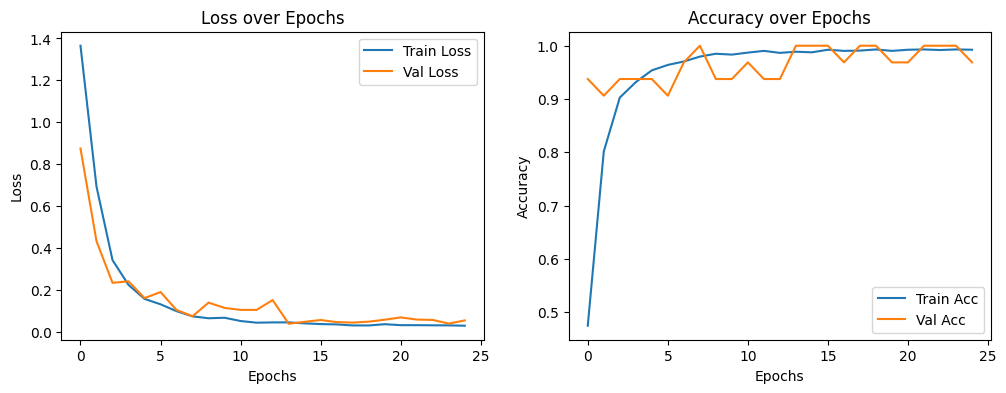

Test Loss: 0.2066 Acc: 0.9250 Precision: 0.9376 Recall: 0.9250 F1: 0.9260


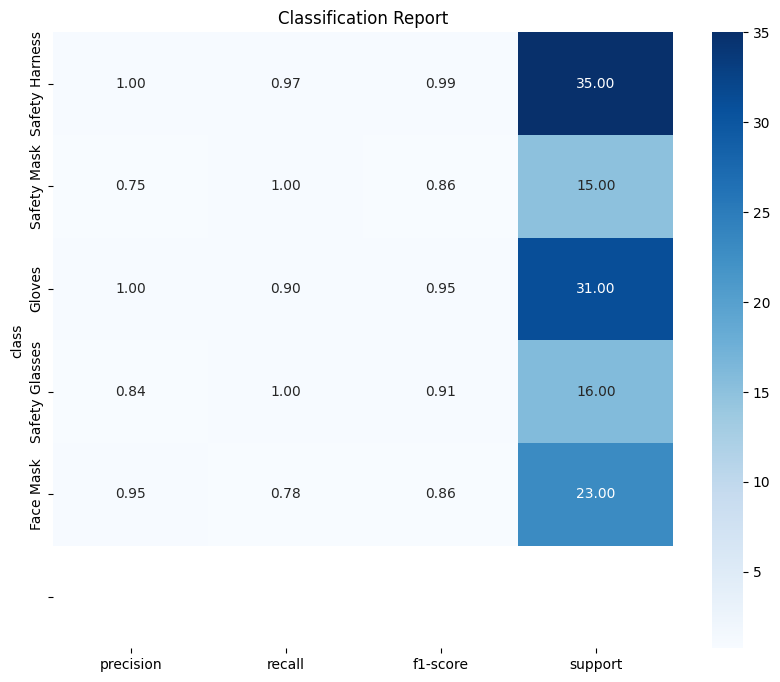

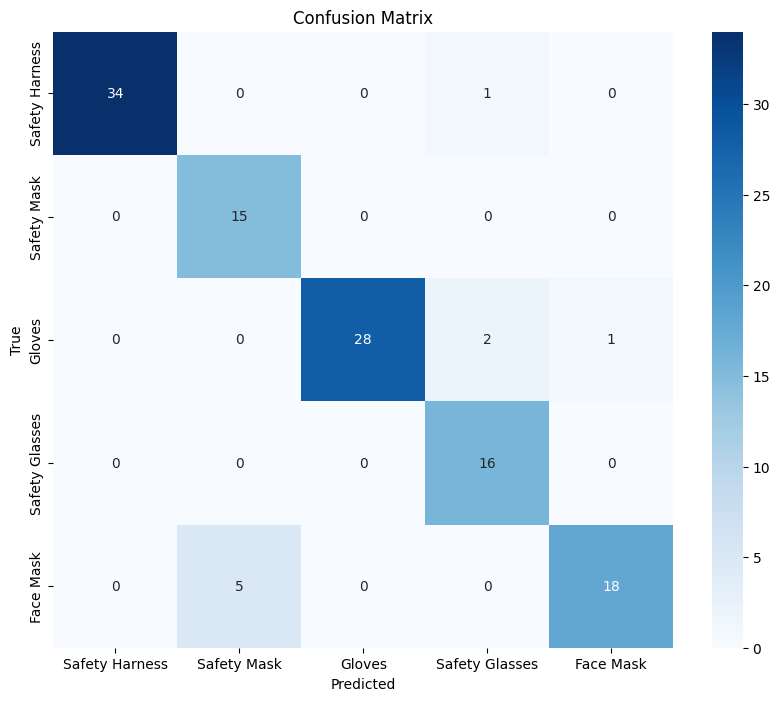

learning_rate,████▇▇▇▆▆▅▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁
train_acc,▁▅▇▇▇████████████████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▁▃▃▃▁▆█▃▃▆▃▃███▆██▆▆███▆
val_loss,█▄▃▃▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,0.0
train_acc,0.99247
train_loss,0.0291
val_acc,0.96875
val_loss,0.05446


In [ ]:
#@title train and evaluate the model
# Initialize wandb
config = {
    "model_type": "ModifiedDenseNet", # BasicCNN, ModifiedResNet, ModifiedDenseNet, DynamicCNN, BasicDNN, EnhancedCNN
    "epochs": 25,
    "batch_size": 32, # no editar.
    "learning_rate": 0.001,
    "momentum": 0.9,
    "scheduler_type": "CosineAnnealingLR",  # or "CosineAnnealingLR", StepLR
    "step_size": 7,
    "gamma": 0.1,
    "T_max": 24,  # Only used for CosineAnnealingLR. Cada cuanto llegar al final. Si se quiere lieal, mismo numero que epocas.
    "dropout_value": 0.5
}

    # Generate a name for the run based on configuration parameters
run_name = (
    f"{config['model_type']}_"
    f"epochs-{config['epochs']}_"
    f"lr-{config['learning_rate']}_"
    f"batch-{config['batch_size']}_"
    f"scheduler-{config['scheduler_type']}"
)
if config["scheduler_type"] == "StepLR":
    run_name += f"_step-{config['step_size']}_gamma-{config['gamma']}"
elif config["scheduler_type"] == "CosineAnnealingLR":
    run_name += f"_Tmax-{config['T_max']}"

# Initialize wandb
wandb.init(
    project="entrega_dos",
    config=config,
    name=run_name  # Set the run name
)

output_folder = "Executions"
run_experiment(config, output_folder)

wandb.finish()